# Read segmentation playground

This notebook is for exploring some ideas related to polymerase read segmentation.  First, we need to install some libraries and set up some helper functions.

In [1]:
import sys
!{sys.executable} -m pip install parasail

In [2]:
import random
import numpy as np
from scipy.sparse import coo_matrix, lil_matrix
import seaborn as sns
import matplotlib.pylab as plt
import networkx as nx
import parasail
import re

In [3]:
def simulate_sequence(length):
    alphabet = ['A', 'C', 'G', 'T']
    
    bases = random.choices(alphabet, k=length)
    bases = ''.join(bases)
    
    return bases

In [4]:
def reverse_complement(seq):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    
    bases = list(seq) 
    bases = reversed([complement.get(base,base) for base in bases])
    bases = ''.join(bases)

    return bases

In [5]:
def canonicalize_kmer(fw_kmer):
    rc_kmer = reverse_complement(fw_kmer)
    
    return fw_kmer if fw_kmer < rc_kmer else rc_kmer

In [6]:
def simulate_unsegmented_ccs_read(fw_seq, num_passes, ccs_fw_adapter, include_rc_adapter = False):
    rc_seq = reverse_complement(fw_seq)
    ccs_rc_adapter = reverse_complement(ccs_fw_adapter)
    
    subreads = []
    for i in range(num_passes):
        subreads.append(fw_seq if i % 2 == 0 else rc_seq)
        
        if i % 2 or include_rc_adapter:
            subreads.append(ccs_fw_adapter if i % 2 == 0 else ccs_rc_adapter)
        
    return subreads

In [7]:
def add_noise(seq, mismatch_rate=0, insertion_rate=0, deletion_rate=0):
    mm_positions = int(mismatch_rate*len(seq))
    ins_positions = int(insertion_rate*len(seq))
    del_positions = int(deletion_rate*len(seq))
    
    newseq = list(seq)
    
    for i in range(mm_positions):
        p = int(random.uniform(0, len(seq)))
        newseq[p] = reverse_complement(newseq[p])

    for i in range(ins_positions):
        p = int(random.uniform(0, len(seq)))
        l = int(random.uniform(2, 5))
        newseq[p] = l*newseq[p]
        
    for i in range(del_positions):
        p = int(random.uniform(0, len(seq)))
        newseq[p] = ''

    return ''.join(newseq)

In [8]:
# For dotplot interpretation and algorithms, see:
# - https://omicstutorials.com/interpreting-dot-plot-bioinformatics-with-an-example/
# - http://www.code10.info/index.php%3Foption%3Dcom_content%26view%3Darticle%26id%3D64:inroduction-to-dot-plots%26catid%3D52:cat_coding_algorithms_dot-plots%26Itemid%3D76

def build_dotplot(seq, kmer_size=7, canonicalize=False):
    A = lil_matrix((len(seq) - kmer_size + 1, len(seq) - kmer_size + 1), dtype=np.int8)
    
    for i in range(len(seq) - kmer_size + 1):
        ki = seq[i:i+kmer_size]
        if canonicalize:
            ki = canonicalize_kmer(ki)
            
        for j in range(len(seq) - kmer_size + 1):
            kj = seq[j:j+kmer_size]
            if canonicalize:
                kj = canonicalize_kmer(kj)
            
            if ki == kj:
                A[i,j] = 1
                
    return A
    

In [9]:
def plot_sparse_matrix(M, segments, size=1, plot_segments=True):
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.rcParams['figure.dpi'] = 100
    
    plt.spy(M, markersize=size)

    if plot_segments:
        offset = 0
        for segment in segments:
            offset += len(segment)

            plt.vlines(offset, 0, len(polymerase_read), colors='red')
            plt.hlines(offset, 0, len(polymerase_read), colors='red')
        

## Simulated read setup

Let's start with a 100-bp genomic fragment with 5 CCS passes and interspersed CCS-adapters (but only for the forward-direction).  We'll take this simulated polymerase read and make four versions of it:

* Perfect read: no mismatches, insertions, or deletions
* 'mm': 10% of bases are mismatches
* 'del': 10% of bases are deleted
* 'ins': 10% of bases are insertions (homopolymers of variable length)

In [10]:
random.seed(0)

fw_seq = simulate_sequence(100)
ccs_adapter = "ATCTCTCTCAACAACAACAACGGAGGAGGAGGAAAAGAGAGAGAT"

segments = simulate_unsegmented_ccs_read(fw_seq, 5, ccs_adapter, include_rc_adapter=False)

polymerase_read = ''.join(segments)
polymerase_read_mm = add_noise(polymerase_read, mismatch_rate=0.1)
polymerase_read_del = add_noise(polymerase_read, deletion_rate=0.1)
polymerase_read_ins = add_noise(polymerase_read, insertion_rate=0.1)

In [11]:
segments

['TTCCGCTCCGTGCTGCTTTTCGTGCACGTTCTCTGAGCTGACTACTAGATTCACGTAGGGTGTGGCGCGCAAGGCATTTTTTGCGCTTTGTGCGTTTAGC',
 'GCTAAACGCACAAAGCGCAAAAAATGCCTTGCGCGCCACACCCTACGTGAATCTAGTAGTCAGCTCAGAGAACGTGCACGAAAAGCAGCACGGAGCGGAA',
 'ATCTCTCTCTTTTCCTCCTCCTCCGTTGTTGTTGTTGAGAGAGAT',
 'TTCCGCTCCGTGCTGCTTTTCGTGCACGTTCTCTGAGCTGACTACTAGATTCACGTAGGGTGTGGCGCGCAAGGCATTTTTTGCGCTTTGTGCGTTTAGC',
 'GCTAAACGCACAAAGCGCAAAAAATGCCTTGCGCGCCACACCCTACGTGAATCTAGTAGTCAGCTCAGAGAACGTGCACGAAAAGCAGCACGGAGCGGAA',
 'ATCTCTCTCTTTTCCTCCTCCTCCGTTGTTGTTGTTGAGAGAGAT',
 'TTCCGCTCCGTGCTGCTTTTCGTGCACGTTCTCTGAGCTGACTACTAGATTCACGTAGGGTGTGGCGCGCAAGGCATTTTTTGCGCTTTGTGCGTTTAGC']

In [12]:
polymerase_read

'TTCCGCTCCGTGCTGCTTTTCGTGCACGTTCTCTGAGCTGACTACTAGATTCACGTAGGGTGTGGCGCGCAAGGCATTTTTTGCGCTTTGTGCGTTTAGCGCTAAACGCACAAAGCGCAAAAAATGCCTTGCGCGCCACACCCTACGTGAATCTAGTAGTCAGCTCAGAGAACGTGCACGAAAAGCAGCACGGAGCGGAAATCTCTCTCTTTTCCTCCTCCTCCGTTGTTGTTGTTGAGAGAGATTTCCGCTCCGTGCTGCTTTTCGTGCACGTTCTCTGAGCTGACTACTAGATTCACGTAGGGTGTGGCGCGCAAGGCATTTTTTGCGCTTTGTGCGTTTAGCGCTAAACGCACAAAGCGCAAAAAATGCCTTGCGCGCCACACCCTACGTGAATCTAGTAGTCAGCTCAGAGAACGTGCACGAAAAGCAGCACGGAGCGGAAATCTCTCTCTTTTCCTCCTCCTCCGTTGTTGTTGTTGAGAGAGATTTCCGCTCCGTGCTGCTTTTCGTGCACGTTCTCTGAGCTGACTACTAGATTCACGTAGGGTGTGGCGCGCAAGGCATTTTTTGCGCTTTGTGCGTTTAGC'

In [13]:
polymerase_read_mm

'TTCCGCTCCGTGGAGGTTTTCCTCCAGGTTCTCTCAGCTGACTACTAGATTCACGTAGGCTGTGGCGCGGAAGCCATTTTTTGCGCATTGTGCGTTTAGGGCTAAAGGCTCAAAGCGGAAAAAAAGCCTTGCGCGCCACACCCAACGAGAATCAAGTAGTCAGCTCAGAGAACGTGCACGAAAAGCAGCACGGAGCCGAAAACTCTGTCTTATCCTCCACCTCCGTTGTTCTTGTTGAGAGAGATTTCCGCACCGTGCTGGTTTTCGTGCACGTTCTCTGAGCTGACTACTAGATTCTCGTAGGGTGTGGCGCGCTAGGCATTTTTTGCGCTTTGTGCCATTAGCGCTAAACCCACATAGCGCAAAAAATGGCTAGCGCGCGACACCCTACGTGAAACAAGAAGTCAGCTCTGAGAACGTGCACGAAAAGCAGCACGGAGCGGAAATCTCTCTCTTTTCCTCCTCCTCGGTTCTTGTTGTTCAGAGAGATTTCCCCTCCGTGCTGCTTTTCGTGCACGTTCTCTGAGCTGACTACTTGATTGACGTAGGGTGAGGCGCGCAAGGCATATTATGCGCTTAGTGCCTTTAGC'

In [14]:
polymerase_read_del

'TCCGCTCGTGCTGCTTTTCGTGCATTCTCTGAGCTGACTACTAGATCACGTAGGGTGTGGCGCGCAAGGCATTTTTTGCGCTTTGTGCTTTAGCGCTAACGCAAAGCGCAAAAAATGCCTTGCGCGCCACACCTACGTAATTAGTAGTCAGCTAGAAACGTGCACGAAACAGCACGGAGCGAATCTCTCCTTCCTCCTCCTCGTTGTGTTGTTGGAGGATCCGCTCCGTGCTGCTTTCGTGCACGTTTCGAGCTGACACTGATTCACGAGGGTGTGGCCGCAAGGCATTTTTTGCGTTGGCGTTTAGCGCTAAACGCACAAAGCGCAAAAATGCCTGGCGCCAACCCTAGTGAATCTAGTAGTCAGCTCAGAAACGTGCCGAAAAGCAGCACGAGCGGAATCTCTCTCTTTTCCTCCTCCTCCGTTGTTGTGTGAGAGAGATTTCCCTCCGTGCTGCTTTTCGTGCAGTTCCTGAGCTGACTACTAGATTCACGTAGGGTGTGGCGCCAAGCATTTTTTGCGCTTTGTGCGTTTAG'

In [15]:
polymerase_read_ins

'TTCCGGGCCTCCGTTGCTGCTTTTCGTGCACGTTTCTCTGAGCCCCTTGACTACTAGATTCACGTAGGGGGGGTGTGGCGCGCAAAAGGCATTTTTTTTGCGCTTTGTGCGTTTTTTAGCGCTAAACGCACAAAGCGCAAAAAAAAAAATGCCTTGCGCGCCACACCCTACGTGAATCTTTTAGTAGTCAGGGCTCCCCAGAGAAAACGTGCACCCCGAAAAGCAAGCACGGAGCGGGGGAAATCCCTCTCTCTTTTCCTCCCCCTCCCCTCCGTTGTTGTTGTTTGAAAAAAAAGAGAGATTTTCCGCTCCGGGTGCTGCTTTTCGGGGTGCACGTTCTCTGAGCCTGACTAAACTAGATTCACGTAGGGTGGGTGGGCGCGCAAGGCATTTTTTTGCGCTTTGTGCGTTTAGCGCTAAACGCACAAAGCGCAAAAAAATTTGCCTTGCGCGCCACCCCCCCCCCCCACCCCCCTACGTGAATCTAGGGTTTAGTCAGCTCAGGGAGGGGAACGTGCACCCCCCGAAAAAAAGCAGCACGGAGCGGGGGGAAATCTCTCTCTTTTCCTCCTCCTCCCCCGTTGTTGTTGTTGAGAGGGAGATTTCCGCTTTTCCGTGCTGCTTTTCGTGCCACGTTCTCTGAGCCCCTGACTTTACTAAAAAAGATTCACGTAGGGTGTGGCGCGGGGCCAAGGCATTTTTTGCGGGCTTTGTGCGTTTAGC'

## Dotplot visualization of auto-alignment

We can visualize how the perfect polymerase read compares to itself using a dotplot: a matrix depicting how subsequences within the read compare to all other parts in the read.  See the following resources for more on dotplots:

* https://omicstutorials.com/interpreting-dot-plot-bioinformatics-with-an-example/
* http://www.code10.info/index.php%3Foption%3Dcom_content%26view%3Darticle%26id%3D64:inroduction-to-dot-plots%26catid%3D52:cat_coding_algorithms_dot-plots%26Itemid%3D76

In [16]:
D = build_dotplot(polymerase_read)

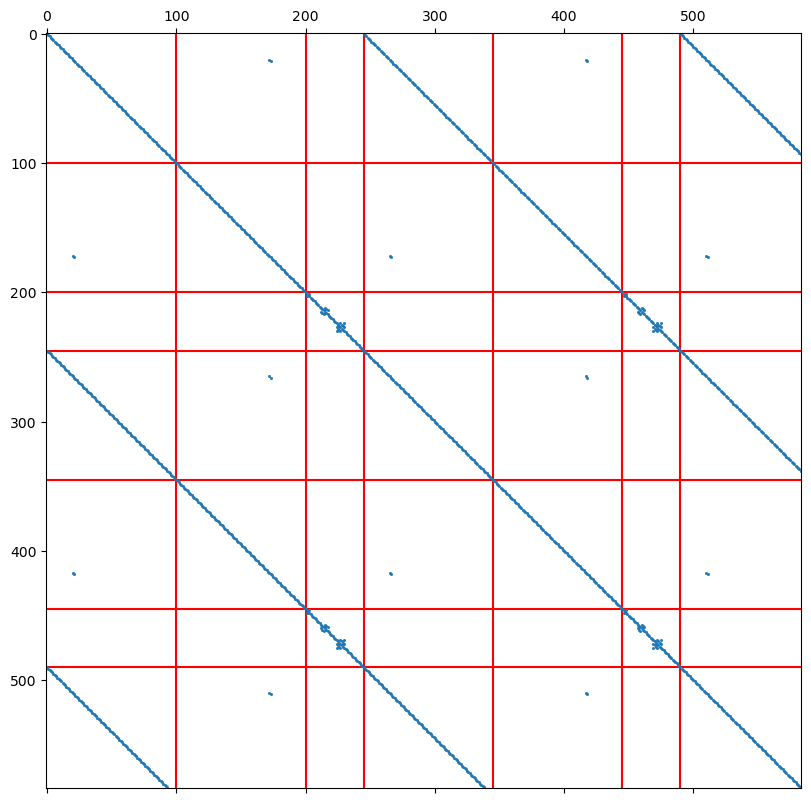

In [17]:
plot_sparse_matrix(D, segments, size=1)

We see a number of parallel diagonal lines: the primary diagonal, and offset diagonals some periodic distance away from the origin.  The red lines denote the lengths of our subreads and the CCS adapter.  Note that the first offset diagonals begin at length `len(forward_subread) + len(rc_subread) + len(ccs_adapter)`, i.e. one repeat of the complete forward and reverse-complement pass plus the CCS adapter sequence.  With this alone, we could probably figure out where to segment the reads into subreads.

However, it might be more convenient if we could somehow make the plot such that it shows us more explicitly where to split between forward and reverse-complement passes.  We can do this by changing our dotplot algorithm to regard forward and reverse-complement kmers as the same thing when populating the matrix.

In [18]:
A = build_dotplot(polymerase_read, canonicalize=True)

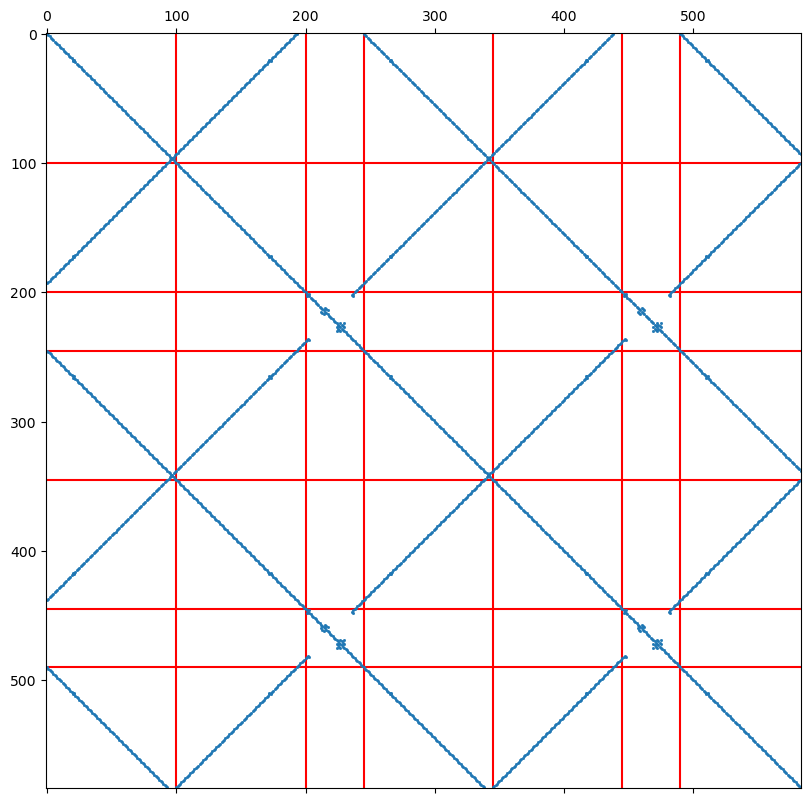

In [19]:
plot_sparse_matrix(A, segments, size=1)

This looks very promising!  The diagonal reads with slope -1 (note that the origin of the plot is in the top-left, not bottom-left as usual) are depicting the reads as inverted repeats.  This is precisely what we expect - these now bisect the polymerase read on the y=x line, telling us where to segment the read.  We can compute the intersections of the inverted repeat lines with the main diagonal to figure out the segmentation positions.

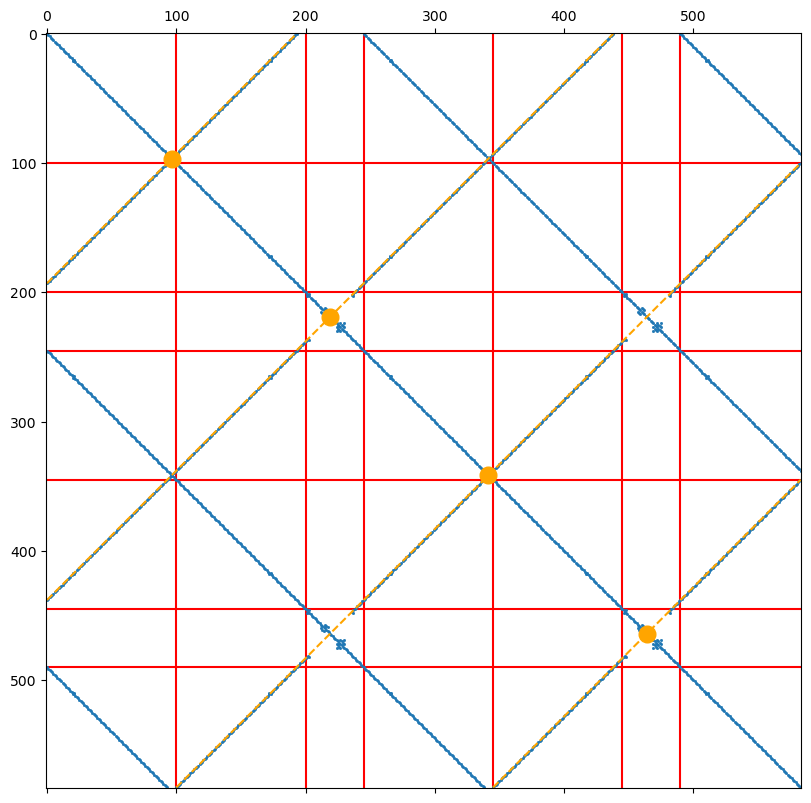

In [20]:
def segment(polymerase_read, A, plot=False, div=2):
    breaks = [0]

    m = -1
    xs = np.array(range(-2*len(polymerase_read), 2*len(polymerase_read), 1))
    for b in range(-2*len(polymerase_read), 2*len(polymerase_read), 1):
        ys = m*xs + b

        xss = xs[(xs >= 0) & (xs < A.shape[0]) & (ys >= 0) & (ys < A.shape[0])]
        yss = ys[(xs >= 0) & (xs < A.shape[0]) & (ys >= 0) & (ys < A.shape[0])]

        v = np.zeros(len(xss))
        for i in range(len(xss)):
            xi = xss[i]
            yi = yss[i]

            v[i] = 1 if A[xi, yi] > 0 else 0

        s = np.sum(v)
        
        if len(v) > 10 and s > len(v)/div:
            xint = b/2
            yint = -1*xint + b

            if plot:
                plt.plot(xss, yss, color='orange', linestyle='dashed')
                plt.plot(xint, yint, color='orange', linestyle='dashed', marker='o', markerfacecolor='orange', markersize=12)

            breaks.append(int(xint))

    subreads = []
    for i in range(len(breaks)-1):
        subread = polymerase_read[breaks[i]:breaks[i+1]]
        subreads.append(subread)
        
    return subreads

plot_sparse_matrix(A, segments)
subreads = segment(polymerase_read, A, plot=True)

Here, we've found the diagonals that seem to have enough points filled in that they're meaningful to us (highlighted with orange dashed lines).  For those lines, we've computed the intersection (the big orange point).  These points all land in the middle of the CCS hairpin adapter, which makes reasonable sense.  Do the sequences look right?

In [21]:
subreads

['TTCCGCTCCGTGCTGCTTTTCGTGCACGTTCTCTGAGCTGACTACTAGATTCACGTAGGGTGTGGCGCGCAAGGCATTTTTTGCGCTTTGTGCGTT',
 'TAGCGCTAAACGCACAAAGCGCAAAAAATGCCTTGCGCGCCACACCCTACGTGAATCTAGTAGTCAGCTCAGAGAACGTGCACGAAAAGCAGCACGGAGCGGAAATCTCTCTCTTTTCCTCCT',
 'CCTCCGTTGTTGTTGTTGAGAGAGATTTCCGCTCCGTGCTGCTTTTCGTGCACGTTCTCTGAGCTGACTACTAGATTCACGTAGGGTGTGGCGCGCAAGGCATTTTTTGCGCTTTGTGCGTT',
 'TAGCGCTAAACGCACAAAGCGCAAAAAATGCCTTGCGCGCCACACCCTACGTGAATCTAGTAGTCAGCTCAGAGAACGTGCACGAAAAGCAGCACGGAGCGGAAATCTCTCTCTTTTCCTCCT']

In [22]:
segments

['TTCCGCTCCGTGCTGCTTTTCGTGCACGTTCTCTGAGCTGACTACTAGATTCACGTAGGGTGTGGCGCGCAAGGCATTTTTTGCGCTTTGTGCGTTTAGC',
 'GCTAAACGCACAAAGCGCAAAAAATGCCTTGCGCGCCACACCCTACGTGAATCTAGTAGTCAGCTCAGAGAACGTGCACGAAAAGCAGCACGGAGCGGAA',
 'ATCTCTCTCTTTTCCTCCTCCTCCGTTGTTGTTGTTGAGAGAGAT',
 'TTCCGCTCCGTGCTGCTTTTCGTGCACGTTCTCTGAGCTGACTACTAGATTCACGTAGGGTGTGGCGCGCAAGGCATTTTTTGCGCTTTGTGCGTTTAGC',
 'GCTAAACGCACAAAGCGCAAAAAATGCCTTGCGCGCCACACCCTACGTGAATCTAGTAGTCAGCTCAGAGAACGTGCACGAAAAGCAGCACGGAGCGGAA',
 'ATCTCTCTCTTTTCCTCCTCCTCCGTTGTTGTTGTTGAGAGAGAT',
 'TTCCGCTCCGTGCTGCTTTTCGTGCACGTTCTCTGAGCTGACTACTAGATTCACGTAGGGTGTGGCGCGCAAGGCATTTTTTGCGCTTTGTGCGTTTAGC']

Roughly, yes.  However, we still have the CCS adapter in there, which would need to be segmented out with a post-processing step.  Perhaps something like what I've started below:

In [23]:
profile_fw = parasail.profile_create_stats_sat(ccs_adapter, parasail.blosum62)
profile_rc = parasail.profile_create_stats_sat(reverse_complement(ccs_adapter), parasail.blosum62)

for sr in subreads:
    res = parasail.sg_qb_de_trace_striped_profile_sat(profile_fw, sr, 11, 1)
    print(res.traceback.ref)
    print(res.traceback.query)
    
    res = parasail.sg_qe_db_trace_striped_profile_sat(profile_fw, sr, 11, 1)
    print(res.traceback.ref)
    print(res.traceback.query)
    
    res = parasail.sg_qb_de_trace_striped_profile_sat(profile_rc, sr, 11, 1)
    print(res.traceback.ref)
    print(res.traceback.query)
    
    res = parasail.sg_qe_db_trace_striped_profile_sat(profile_rc, sr, 11, 1)
    print(res.traceback.ref)
    print(res.traceback.query)
    
    print()

TTCCGCTCCGTGCTGCTTTTCGTGCACGTTCTCTGAGCTGACTACTAGATTCACGTAGGGTGTGGCGCGCAAGGCATTTTTTGCGCTTTGTGCGTT
ATC--------------------------TCTCT-------CAACAACAACAACGGAGGAGGAGGAAAAGAGAGAGAT------------------
TTCCGCTCCGTGCTGCTTTTCGTGCACGTTCTCTGAGCTGACTACTAGATTCACGTAGGGTGTGGCGCGCAAGGCATTTTTTGCGCTTTGTGCGTT
----------------------------ATCTCT---CT--CAACAACAACAACGGAGGAGGAGG---AAAAG---------------AGAGAGAT
TTCCGCTCCGTGCTGCTTTTCGTGCACGTTCTCTGAGCTGACTACTAGATTCACGTAGGGTGTGGCGCGCAAGGCATTTTTTGCGCTTTGTGCGTT
ATCT-CTCT------CTTTTC---CTC---CTC--------CTCCGTTGTTGTTGTTGAGAGAGAT------------------------------
TTCCGCTCCGTGCTGCTTTTCGTGCACGTTCTCTGAGCTGACTACTAGATTCACGTAGGGTGTGGCGCGCAAGGCATTTTTTGCGCTTTGTGCGTT
------------------------ATCTCTCTCTTTTCCTCCTCCT------CCGT----TGTTG------------TTGTTG-----AGAGAGAT

-TAGCGCTAAACGCACAAAGCGCA-AAAAATGCCTTGCGCGCCACACCCTACGTGAATCTAGTAGTCAGCTCAGAGAACGTGCACGAAAAGCAGCACGGAGCGGAAATCTCTCTCTTTTCCTCCT
ATCTCTCTCAACAACAACAACGGAGGAGGAGGAAAAGAGAGAGAT----------------------------------------------------

Using semi-global alignments, we can see half of the adapter align to the beginning or end of each read.  This should give us some insight into how to post-process the segmented reads to reflect only genomic/transcriptomic sequence.

## Coping with sequencing errors

How does this approach generalize to errorful sequences?  Let's examine what happens with just mismatches.

['TTCCGCTCCGTGGAGGTTTTCCTCCAGGTTCTCTCAGCTGACTACTAGATTCACGTAGGCTGTGGCGCGGAAGCCATTTTTTGCGCATTGTGCGTT',
 'TAGGGCTAAAGGCTCAAAGCGGAAAAAAAGCCTTGCGCGCCACACCCAACGAGAATCAAGTAGTCAGCTCAGAGAACGTGCACGAAAAGCAGCACGGAGCCGAAAACTCTGTCTTATCCTCCA',
 'CCTCCGTTGTTCTTGTTGAGAGAGATTTCCGCACCGTGCTGGTTTTCGTGCACGTTCTCTGAGCTGACTACTAGATTCTCGTAGGGTGTGGCGCGCTAGGCATTTTTTGCGCTTTGTGCCAT',
 'TAGCGCTAAACCCACATAGCGCAAAAAATGGCTAGCGCGCGACACCCTACGTGAAACAAGAAGTCAGCTCTGAGAACGTGCACGAAAAGCAGCACGGAGCGGAAATCTCTCTCTTTTCCTCCT']

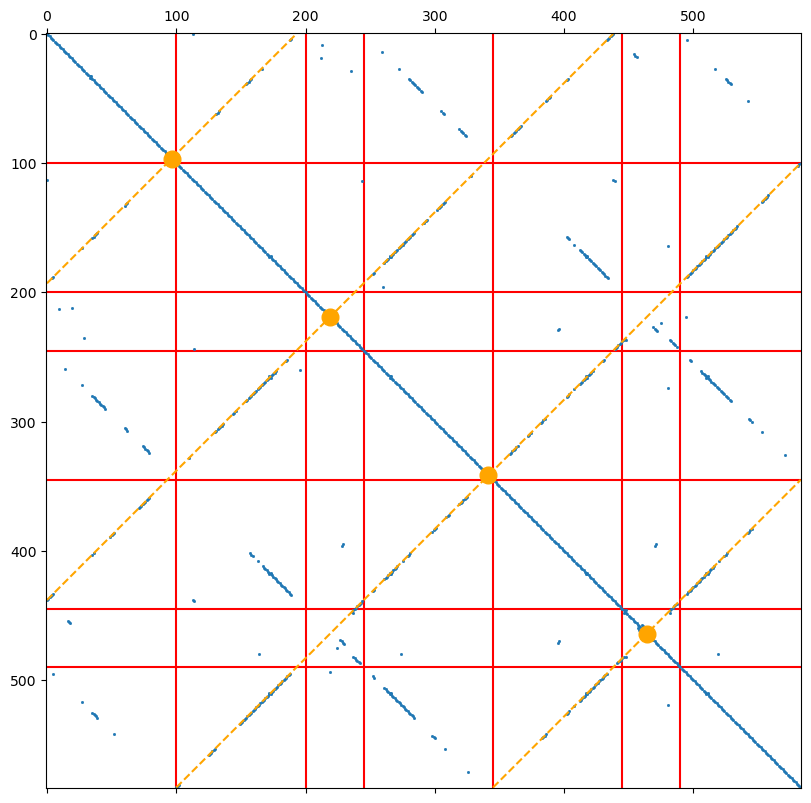

In [24]:
B = build_dotplot(polymerase_read_mm, canonicalize=True)
plot_sparse_matrix(B, segments)
segment(polymerase_read_mm, B, plot=True, div=9)

Well, looks like things still work if it's just mismatches.  There's less filled in on the inverted diagonals, but enough that we can still find what we're looking for.

How about 1-bp deletions?

['TCCGCTCGTGCTGCTTTTCGTGCATTCTCTGAGCTGACTACTAGATCACGTAGGGTGTGGCGCGCAAGGCATTTTTTGCGCTTTGTGCT',
 'TTAGCGCTAACGCAAAGCGCAAAAAATGCCTTGCGCGCCACACCTACGTAATTAGTAGTCAGCTAGAAACGTGCACGAAACAGCACGGAGCGAATCTCTCCTTCCTC',
 'CTCCTCGTTGTGTTGTTGGAGGATCCGCTCCGTGCTGCTTTCGTGCACGTTTCGAGCTGACACTGATTCACGAGGGTGTGGCCGCAAGGCATTTTTTGCGTTGGCGTTTAGCGCTAAACGCACAAAGCGCAAAAATGCCTGGCGCCAACCCTAGTGAATCTAGTAGTCAGCTCAGAAACGTGCCGAAAAGCAGCACGAGCGGAATCTCTCTCTTTTCCTCC',
 'TC']

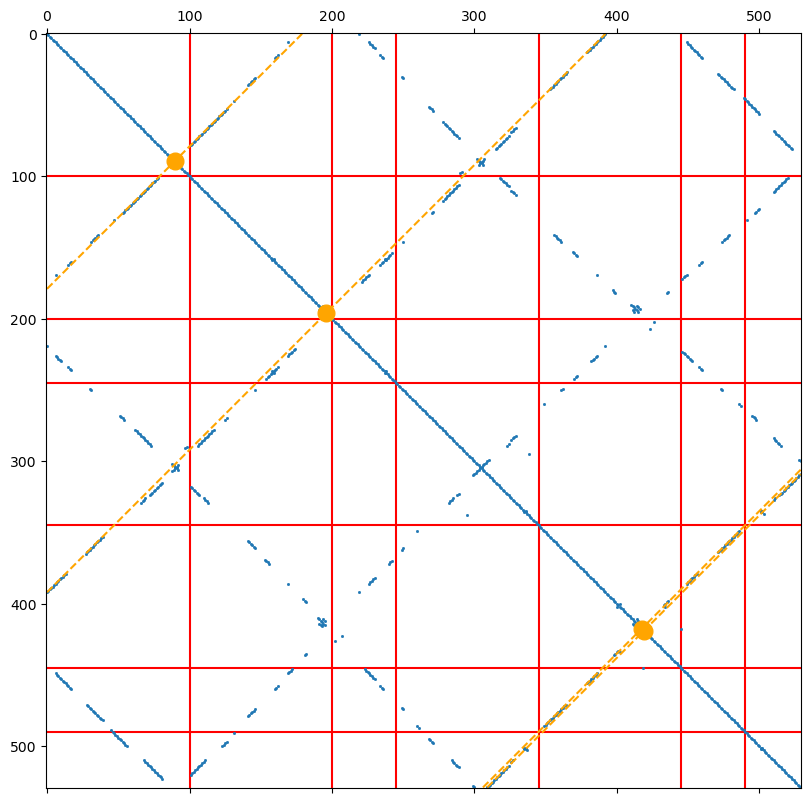

In [25]:
D = build_dotplot(polymerase_read_del, canonicalize=True)
plot_sparse_matrix(D, segments)
segment(polymerase_read_del, D, plot=True, div=7)

Same finding.  How about variable-length (but short) homopolymer insertions?

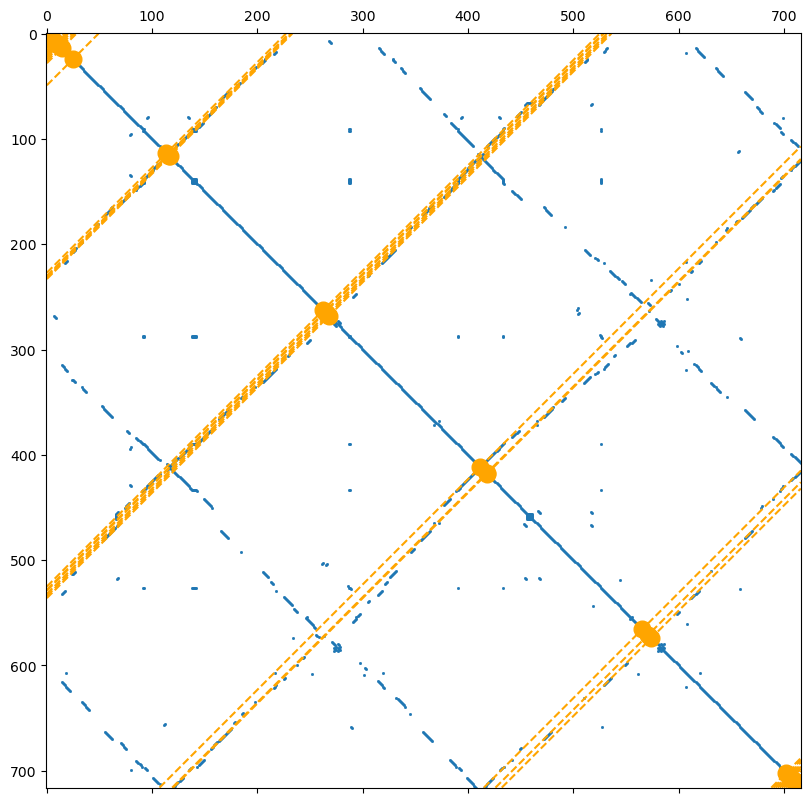

In [26]:
C = build_dotplot(polymerase_read_ins, canonicalize=True)
plot_sparse_matrix(C, segments, plot_segments=False)
q = segment(polymerase_read_ins, C, plot=True, div=30)

Now we're running into some problems.  Visually we can still see the pattern we're looking for, but the filled-in points don't all lie on the same line; they've been offset by the presence of the insertions.  Note also that we're not showing the red lines depicting the original sequences; the insertions are long and frequent enough that the new sequence is much longer than the original, and all of the original subread offsets are wrong.

This plot suggests we may need to perform two corrections.  First, run-length encoding the read prior to constructing the matrix should help substantially.  Second, rather than considering single lines, we may want to consider a banded approach - a small diagonal rectangle centered on the original line.  Both of these measures may help us compensate for errors.